In [1]:
from GCN_model import GCN

import torch_geometric
import torch
import numpy as np

import torch.nn as nn
import torch_geometric.datasets as datasets


import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


c:\Users\ckaz3\miniconda3\envs\grl_mini_project\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [3]:
def evaluate(
        model,
        data,
        mask):
    
    edge_index = torch_geometric.EdgeIndex(dataset.edge_index)
    adj_matrix = edge_index.to_dense()
    
    output = model(data.x, adj_matrix)

    output = torch.argmax(output[mask], dim=1)
    target = data.y[mask]

    return torch.mean((output == target).float())

In [4]:
def train(
    num_layers: int,
    aug_adj_type: str,
    lr: int,
    weight_decay: int,
    num_epochs: int,
    dataset,
    verbose: bool = True
) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data = dataset.data
    data = data.to(device)

    # calculate adjacency matrix
    edge_index = torch_geometric.EdgeIndex(dataset.edge_index)
    adj_matrix = edge_index.to_dense().to(device)

    model = GCN(
        in_channels=dataset.num_features,
        hidden_channels=64,
        out_channels=dataset.num_classes,
        num_layers=num_layers,
        aug_adj_type=aug_adj_type,
        dropout=0.3,
    ).to(device)

    losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    early_stop_counter = 0
    prev_val_acc = 1.1

    for i in range(num_epochs):
        optimizer.zero_grad()

        outputs = model(data.x.to(device), adj_matrix.to(device))

        loss = criterion(outputs[data.train_mask], data.y[data.train_mask])
        losses.append(loss)

        loss.backward()
        optimizer.step()

        # check for early-stopping
        val_acc = evaluate(model, data, data.val_mask)

        if val_acc < prev_val_acc:
            if prev_val_acc != 1.1:
                early_stop_counter += 1
            prev_val_acc = val_acc

            if early_stop_counter == 5:
                break
        else:
            prev_val_acc = 1.1
            early_stop_counter = 0

        if i % 5 == 0 and verbose:
            print(f"Epoch: {i}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")

    if verbose:
        print(f"Epoch: {i}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")
    return model

In [18]:
# # do not run

# study_data = {"symmetric": {}, "degree": {}, "adjacency": {}, "random walk": {}}

# f = open("results_2.pkl", "wb")
# pickle.dump(study_data, f)
# f.close()

In [5]:
layers = [0, 1] 
layers.extend(np.arange(2, 26, 2))

with open("results_2.pkl", "rb") as file:
    study_data = pickle.load(file)

for aug_adj_type in study_data:
    for num_layers in tqdm(layers):
        if num_layers in study_data[aug_adj_type]:
            continue

        print(aug_adj_type, num_layers)

        # train model
        torch.manual_seed(2025)
        np.random.seed(2025)
        
        model = train(
            num_layers=num_layers,
            aug_adj_type=aug_adj_type,
            lr=0.001,
            weight_decay=0.0001,
            num_epochs=100,
            dataset=dataset,
            verbose=False
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"

        data = dataset.data
        data = data.to(device)

        test_acc = evaluate(model, data, data.test_mask)

        study_data[aug_adj_type][num_layers] = test_acc
        
        f = open("results_2.pkl", "wb")
        pickle.dump(study_data, f)
        f.close()

  0%|          | 0/14 [00:00<?, ?it/s]

symmetric 1


 14%|█▍        | 2/14 [00:09<00:55,  4.64s/it]

symmetric 2


 21%|██▏       | 3/14 [00:25<01:44,  9.50s/it]

symmetric 4


 29%|██▊       | 4/14 [00:54<02:47, 16.79s/it]

symmetric 6


 36%|███▌      | 5/14 [01:37<03:54, 26.01s/it]

symmetric 8


 43%|████▎     | 6/14 [02:40<05:03, 37.99s/it]

symmetric 10


 50%|█████     | 7/14 [04:21<06:48, 58.33s/it]

symmetric 12


 57%|█████▋    | 8/14 [06:29<08:01, 80.19s/it]

symmetric 14


 64%|██████▍   | 9/14 [08:57<08:27, 101.52s/it]

symmetric 16


 71%|███████▏  | 10/14 [11:48<08:10, 122.58s/it]

symmetric 18


 79%|███████▊  | 11/14 [14:59<07:10, 143.44s/it]

symmetric 20


 86%|████████▌ | 12/14 [18:30<05:28, 164.10s/it]

symmetric 22


 93%|█████████▎| 13/14 [22:22<03:04, 184.51s/it]

symmetric 24


  0%|          | 0/14 [00:00<?, ?it/s]

degree 0


  7%|▋         | 1/14 [00:00<00:09,  1.35it/s]

degree 1


 14%|█▍        | 2/14 [00:04<00:26,  2.22s/it]

degree 2


 21%|██▏       | 3/14 [00:07<00:31,  2.86s/it]

degree 4


 29%|██▊       | 4/14 [00:11<00:34,  3.44s/it]

degree 6


 36%|███▌      | 5/14 [00:17<00:36,  4.03s/it]

degree 8


 43%|████▎     | 6/14 [00:22<00:36,  4.62s/it]

degree 10


 50%|█████     | 7/14 [00:29<00:36,  5.23s/it]

degree 12


 57%|█████▋    | 8/14 [00:36<00:35,  5.92s/it]

degree 14


 64%|██████▍   | 9/14 [00:44<00:32,  6.54s/it]

degree 16


 71%|███████▏  | 10/14 [00:53<00:28,  7.17s/it]

degree 18


 79%|███████▊  | 11/14 [01:02<00:23,  7.82s/it]

degree 20


 86%|████████▌ | 12/14 [01:12<00:17,  8.56s/it]

degree 22


 93%|█████████▎| 13/14 [01:24<00:09,  9.39s/it]

degree 24


  0%|          | 0/14 [00:00<?, ?it/s]

adjacency 0


  7%|▋         | 1/14 [00:00<00:09,  1.37it/s]

adjacency 1


 14%|█▍        | 2/14 [00:03<00:26,  2.22s/it]

adjacency 2


 21%|██▏       | 3/14 [00:07<00:31,  2.87s/it]

adjacency 4


 29%|██▊       | 4/14 [00:11<00:34,  3.45s/it]

adjacency 6


 36%|███▌      | 5/14 [00:17<00:36,  4.03s/it]

adjacency 8


 43%|████▎     | 6/14 [00:22<00:36,  4.62s/it]

adjacency 10


 50%|█████     | 7/14 [00:29<00:36,  5.22s/it]

adjacency 12


 57%|█████▋    | 8/14 [00:36<00:35,  5.85s/it]

adjacency 14


 64%|██████▍   | 9/14 [00:44<00:32,  6.49s/it]

adjacency 16


 71%|███████▏  | 10/14 [00:53<00:28,  7.16s/it]

adjacency 18


 79%|███████▊  | 11/14 [01:02<00:23,  7.84s/it]

adjacency 20


 86%|████████▌ | 12/14 [01:12<00:17,  8.51s/it]

adjacency 22


 93%|█████████▎| 13/14 [01:23<00:09,  9.18s/it]

adjacency 24


  0%|          | 0/14 [00:00<?, ?it/s]

random walk 0


  7%|▋         | 1/14 [00:00<00:09,  1.38it/s]

random walk 1


 14%|█▍        | 2/14 [00:08<00:58,  4.85s/it]

random walk 2


 21%|██▏       | 3/14 [00:20<01:31,  8.33s/it]

random walk 4


 29%|██▊       | 4/14 [00:42<02:16, 13.68s/it]

random walk 6


 36%|███▌      | 5/14 [01:14<03:00, 20.06s/it]

random walk 8


 43%|████▎     | 6/14 [01:55<03:37, 27.15s/it]

random walk 10


 50%|█████     | 7/14 [02:42<03:56, 33.74s/it]

random walk 12


 57%|█████▋    | 8/14 [03:28<03:46, 37.77s/it]

random walk 14


 64%|██████▍   | 9/14 [04:19<03:29, 41.86s/it]

random walk 16


 71%|███████▏  | 10/14 [05:20<03:11, 47.84s/it]

random walk 18


 79%|███████▊  | 11/14 [06:22<02:36, 52.01s/it]

random walk 20


 86%|████████▌ | 12/14 [07:28<01:52, 56.36s/it]

random walk 22


 93%|█████████▎| 13/14 [08:40<01:01, 61.04s/it]

random walk 24


100%|██████████| 14/14 [09:56<00:00, 42.60s/it]


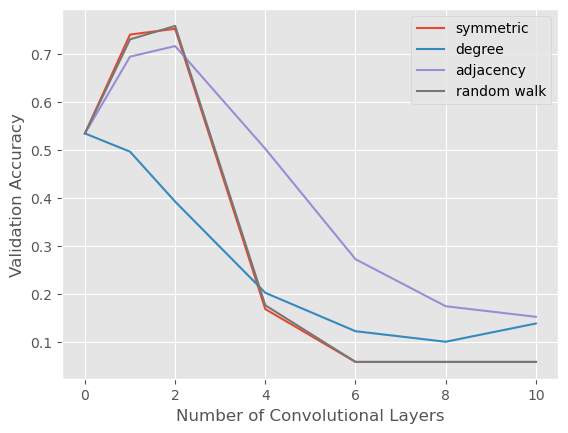

In [17]:
with open("data.pkl", "rb") as file:
    plotting_data = pickle.load(file)

types = list(plotting_data.keys())
layer_tests = list(plotting_data["symmetric"].keys())[:-3]

plt.style.use('ggplot')

for type in types:
    plt.plot(layer_tests, [plotting_data[type][i] for i in layer_tests], label=type)

plt.xlabel("Number of Convolutional Layers")
plt.ylabel("Test Accuracy")
plt.legend()